In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [9]:
dictionary={
    'Chembarambaakam':0,
    'Chozhavaram':1,
    'Poondi':2,
    'RedHills':3
}
revdict={
   
    0:'Chembarambaakam',
    1:'Chozhavaram',
    2:'Poondi',
    3:'RedHills'
}

dataset=[]
    
dataset.append(pd.read_csv(r'C:\Users\user\Desktop\DMTproj\datasets\CHdianna.csv'))
dataset.append(pd.read_csv(r'C:\Users\user\Desktop\DMTproj\datasets\CZdianna.csv'))
dataset.append(pd.read_csv(r'C:\Users\user\Desktop\DMTproj\datasets\PNdianna.csv'))
dataset.append(pd.read_csv(r'C:\Users\user\Desktop\DMTproj\datasets\RHdianna.csv'))

for i in range(0,4):
    print('\n',revdict[i],':\n')
    dataset[i]=dataset[i].dropna()
    print(dataset[i].tail())


 Chembarambaakam :

            Date  nth day in year  Storage (mcft)  Inflow (cusecs)  \
5109  27/12/2017              360          1863.0              0.0   
5110  28/12/2017              361          1859.0              0.0   
5111  29/12/2017              362          1855.0              0.0   
5112  30/12/2017              363          1851.0              0.0   
5113  31/12/2017              364          1847.0              0.0   

      Rainfall (mm)  Outflow (cusecs)  
5109            0.0                49  
5110            0.0                49  
5111            0.0                49  
5112            0.0                49  
5113            0.0                49  

 Chozhavaram :

            Date  nth day in year  Storage (mcft)  Inflow (cusecs)  \
5109  27/12/2017              360           528.0              0.0   
5110  28/12/2017              361           525.0              0.0   
5111  29/12/2017              362           522.0              0.0   
5112  30/12/2017     

In [10]:
def drop_columns(data):
    siro=data.drop(columns=['Date','nth day in year'])
    '''for i in ['Storage (mcft)', 'Inflow (cusecs)','Rainfall (mm)','Outflow (cusecs)']:
    siro[i]-=min(galactus[i])
    siro[i]/=(max(galactus[i])-min(galactus[i]))'''
    return siro

def sequence_prepare(raw,lookback=5):
    shape=((len(raw)-lookback),lookback,raw.shape[-1])
    sequence=np.zeros(shape)
    target=np.zeros(len(raw)-lookback)

    for i in range(lookback, len(raw)):
        for j in range(0,lookback):
              sequence[i-lookback][j]=raw.loc[i+j-lookback,:]
        target[i-lookback]=raw['Outflow (cusecs)'][i]

    return sequence,target



In [12]:
siro=[]
target=[]
for i in range(0,4):
    x=drop_columns(dataset[i])
    x,y=sequence_prepare(x)
    siro.append(x)
    target.append(y)


    

[array([[[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]],
 
        [[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]],
 
        [[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.]],
 
        ...,
 
        [[1875.,    0.,    0.,   48.],
         [1871.,    0.,    0.,   54.],
         [1867.,    0.,    0.,   49.],
         [1863.,    0.,    0.,   49.],
         [1859.,    0.,    0.,   49.]],
 
        [[1871.,    0.,    0.,   54.],
         [1867.,    0.,    0.,   49.],
         [1863.,    0.,    0.,   49.],
         [1859.,    0.,    0.,   49.],
         [1855.,    0.,    0.,   49.]

In [17]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

from sklearn.model_selection import train_test_split

for i in range(0,4):
    Xtrain, Xtest, ytrain, ytest = train_test_split( siro[i], target[i], test_size=0.2, random_state=0)
    x_train.append(Xtrain)
    y_train.append(ytrain)
    x_test.append(Xtest)
    y_test.append(ytest)

print(x_train[0].shape)
print(x_test[0].shape)


(4087, 5, 4)
(1022, 5, 4)


In [79]:
from keras.layers import Conv2D, MaxPooling1D, Concatenate, Activation, Dropout, Flatten, Dense
from tensorflow.keras import layers
# Creating Model

xin=[]
lstm=[]
cnn_raw=[]
cnn=[]
x=[]
xout=[]
xd=[]
lookback=5
for i in range(0,4):
    xin.append(layers.Input(shape=(lookback,4),name=('Input'+str(i+1))))
    lstm.append(layers.LSTM(32,dropout=0.1,recurrent_dropout=0.5,activation='relu',return_sequences=True,name=('LSTM'+str(i+1)))(xin[i]))
    
    lay1= layers.Conv1D(32,1,activation='relu')(xin[i])
    con=  layers.Concatenate(name=('C-Cat'+str(i)))([lstm[i], lay1])
    
    lay2= layers.Dense(16, activation='relu')(con)
    lay3= layers.Dense(32, activation='relu')(lay2)
    flat=layers.Flatten()(lay2)
    xout.append(layers.Dense(1,activation='relu',name=('outut'+str(i+1)))(flat))                                               
    



In [90]:
from tensorflow.keras import models
from keras.optimizers import Adam, RMSprop
all_models=[]
for i in range(0,4):
    
    model=models.Model(inputs=xin[i],outputs=xout[i])
    model.compile(loss='mae', optimizer='rmsprop',metrics=["mae", "acc"])
    all_models.append(model)

In [93]:
model_history=[]
fitted_models=[]
for i in range(0,4):
    history = all_models[i].fit(x_train[i], y_train[i],epochs=100,batch_size=128,validation_data=(x_test[i], y_test[i]),verbose=1)
    model_history.append(history)
    fitted_models.append(model)
    


Epoch 1/100
32/32 [==============================] - 0s 11ms/step - loss: 45.3195 - mae: 45.3195 - acc: 0.1028 - val_loss: 31.5965 - val_mae: 31.5965 - val_acc: 0.0949
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 43.0521 - mae: 43.0521 - acc: 0.1033 - val_loss: 30.8504 - val_mae: 30.8504 - val_acc: 0.0988
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 43.2533 - mae: 43.2533 - acc: 0.1062 - val_loss: 33.9621 - val_mae: 33.9621 - val_acc: 0.0959
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 43.6903 - mae: 43.6903 - acc: 0.1033 - val_loss: 34.4227 - val_mae: 34.4227 - val_acc: 0.0959
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 43.0092 - mae: 43.0092 - acc: 0.1020 - val_loss: 33.4042 - val_mae: 33.4042 - val_acc: 0.0969
Epoch 6/100
32/32 [==============================] - 0s 9ms/step - loss: 42.3879 - mae: 42.3879 - acc: 0.1042 - val_loss: 30.6137 - val_mae: 30.6137 - val_acc: 0.1

Epoch 50/100
32/32 [==============================] - 0s 8ms/step - loss: 37.2079 - mae: 37.2079 - acc: 0.1099 - val_loss: 28.6421 - val_mae: 28.6421 - val_acc: 0.1321
Epoch 51/100
32/32 [==============================] - 0s 9ms/step - loss: 37.0164 - mae: 37.0164 - acc: 0.1126 - val_loss: 27.7508 - val_mae: 27.7508 - val_acc: 0.1341
Epoch 52/100
32/32 [==============================] - 0s 9ms/step - loss: 36.8105 - mae: 36.8105 - acc: 0.1128 - val_loss: 29.2904 - val_mae: 29.2904 - val_acc: 0.1350
Epoch 53/100
32/32 [==============================] - 0s 9ms/step - loss: 37.8349 - mae: 37.8349 - acc: 0.1140 - val_loss: 26.2999 - val_mae: 26.2999 - val_acc: 0.1341
Epoch 54/100
32/32 [==============================] - 0s 10ms/step - loss: 37.3991 - mae: 37.3991 - acc: 0.1116 - val_loss: 27.9620 - val_mae: 27.9620 - val_acc: 0.1341
Epoch 55/100
32/32 [==============================] - 0s 9ms/step - loss: 37.5591 - mae: 37.5591 - acc: 0.1133 - val_loss: 29.8323 - val_mae: 29.8323 - val_acc

Epoch 99/100
32/32 [==============================] - 0s 8ms/step - loss: 35.7934 - mae: 35.7934 - acc: 0.1226 - val_loss: 26.1719 - val_mae: 26.1719 - val_acc: 0.1311
Epoch 100/100
32/32 [==============================] - 0s 9ms/step - loss: 34.8747 - mae: 34.8747 - acc: 0.1214 - val_loss: 29.3988 - val_mae: 29.3988 - val_acc: 0.1341
Epoch 1/100
32/32 [==============================] - 0s 10ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2346 - val_mae: 17.2346 - val_acc: 0.7916
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2346 - val_mae: 17.2346 - val_acc: 0.7916
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2346 - val_mae: 17.2346 - val_acc: 0.7916
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2346 - val_mae: 17.2346 - val_acc: 0

Epoch 48/100
32/32 [==============================] - 0s 8ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 49/100
32/32 [==============================] - 0s 9ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 50/100
32/32 [==============================] - 0s 8ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 51/100
32/32 [==============================] - 0s 9ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 52/100
32/32 [==============================] - 0s 8ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 53/100
32/32 [==============================] - 0s 8ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc:

Epoch 97/100
32/32 [==============================] - 0s 9ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 98/100
32/32 [==============================] - 0s 8ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 99/100
32/32 [==============================] - 0s 9ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 100/100
32/32 [==============================] - 0s 9ms/step - loss: 20.3660 - mae: 20.3660 - acc: 0.7597 - val_loss: 17.2329 - val_mae: 17.2329 - val_acc: 0.7926
Epoch 1/100
32/32 [==============================] - 0s 11ms/step - loss: 71.9001 - mae: 71.9001 - acc: 0.2209 - val_loss: 82.3302 - val_mae: 82.3302 - val_acc: 0.2221
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 71.4943 - mae: 71.4943 - acc: 0.2253 - val_loss: 79.5540 - val_mae: 79.5540 - val_acc:

Epoch 46/100
32/32 [==============================] - 0s 9ms/step - loss: 68.5924 - mae: 68.5924 - acc: 0.2461 - val_loss: 81.2823 - val_mae: 81.2823 - val_acc: 0.2583
Epoch 47/100
32/32 [==============================] - 0s 8ms/step - loss: 68.8207 - mae: 68.8207 - acc: 0.2520 - val_loss: 81.4692 - val_mae: 81.4692 - val_acc: 0.2397
Epoch 48/100
32/32 [==============================] - 0s 9ms/step - loss: 67.5039 - mae: 67.5039 - acc: 0.2469 - val_loss: 79.6665 - val_mae: 79.6665 - val_acc: 0.2466
Epoch 49/100
32/32 [==============================] - 0s 8ms/step - loss: 70.1520 - mae: 70.1520 - acc: 0.2442 - val_loss: 80.2960 - val_mae: 80.2960 - val_acc: 0.2417
Epoch 50/100
32/32 [==============================] - 0s 9ms/step - loss: 68.4585 - mae: 68.4585 - acc: 0.2425 - val_loss: 81.9648 - val_mae: 81.9648 - val_acc: 0.2593
Epoch 51/100
32/32 [==============================] - 0s 9ms/step - loss: 68.0184 - mae: 68.0184 - acc: 0.2466 - val_loss: 80.3583 - val_mae: 80.3583 - val_acc:

Epoch 95/100
32/32 [==============================] - 0s 9ms/step - loss: 67.6202 - mae: 67.6202 - acc: 0.2530 - val_loss: 80.9636 - val_mae: 80.9636 - val_acc: 0.2613
Epoch 96/100
32/32 [==============================] - 0s 9ms/step - loss: 66.9251 - mae: 66.9251 - acc: 0.2542 - val_loss: 85.0317 - val_mae: 85.0317 - val_acc: 0.2603
Epoch 97/100
32/32 [==============================] - 0s 8ms/step - loss: 66.7579 - mae: 66.7579 - acc: 0.2540 - val_loss: 87.7727 - val_mae: 87.7727 - val_acc: 0.2417
Epoch 98/100
32/32 [==============================] - 0s 8ms/step - loss: 66.7474 - mae: 66.7474 - acc: 0.2501 - val_loss: 84.5809 - val_mae: 84.5809 - val_acc: 0.2544
Epoch 99/100
32/32 [==============================] - 0s 8ms/step - loss: 65.7790 - mae: 65.7790 - acc: 0.2528 - val_loss: 87.4324 - val_mae: 87.4324 - val_acc: 0.2622
Epoch 100/100
32/32 [==============================] - 0s 9ms/step - loss: 66.2813 - mae: 66.2813 - acc: 0.2515 - val_loss: 81.0433 - val_mae: 81.0433 - val_acc

Epoch 44/100
32/32 [==============================] - 0s 8ms/step - loss: 17.3596 - mae: 17.3596 - acc: 0.0247 - val_loss: 20.0938 - val_mae: 20.0938 - val_acc: 0.0245
Epoch 45/100
32/32 [==============================] - 0s 9ms/step - loss: 17.6839 - mae: 17.6839 - acc: 0.0250 - val_loss: 18.8447 - val_mae: 18.8447 - val_acc: 0.0245
Epoch 46/100
32/32 [==============================] - 0s 9ms/step - loss: 17.2534 - mae: 17.2534 - acc: 0.0245 - val_loss: 18.3319 - val_mae: 18.3319 - val_acc: 0.0245
Epoch 47/100
32/32 [==============================] - 0s 11ms/step - loss: 17.3897 - mae: 17.3897 - acc: 0.0257 - val_loss: 21.0064 - val_mae: 21.0064 - val_acc: 0.0254
Epoch 48/100
32/32 [==============================] - 0s 15ms/step - loss: 17.5159 - mae: 17.5159 - acc: 0.0250 - val_loss: 19.5266 - val_mae: 19.5266 - val_acc: 0.0225
Epoch 49/100
32/32 [==============================] - 0s 15ms/step - loss: 17.2023 - mae: 17.2023 - acc: 0.0237 - val_loss: 18.8749 - val_mae: 18.8749 - val_a

32/32 [==============================] - 0s 9ms/step - loss: 15.7869 - mae: 15.7869 - acc: 0.0247 - val_loss: 19.9198 - val_mae: 19.9198 - val_acc: 0.0235
Epoch 93/100
32/32 [==============================] - 0s 9ms/step - loss: 15.9069 - mae: 15.9069 - acc: 0.0250 - val_loss: 20.1572 - val_mae: 20.1572 - val_acc: 0.0245
Epoch 94/100
32/32 [==============================] - 0s 9ms/step - loss: 15.9152 - mae: 15.9152 - acc: 0.0242 - val_loss: 19.6730 - val_mae: 19.6730 - val_acc: 0.0245
Epoch 95/100
32/32 [==============================] - 0s 9ms/step - loss: 15.6534 - mae: 15.6534 - acc: 0.0252 - val_loss: 19.3909 - val_mae: 19.3909 - val_acc: 0.0254
Epoch 96/100
32/32 [==============================] - 0s 12ms/step - loss: 15.8452 - mae: 15.8452 - acc: 0.0250 - val_loss: 19.0564 - val_mae: 19.0564 - val_acc: 0.0245
Epoch 97/100
32/32 [==============================] - 0s 9ms/step - loss: 15.5631 - mae: 15.5631 - acc: 0.0245 - val_loss: 17.1114 - val_mae: 17.1114 - val_acc: 0.0225
Epoc

In [86]:


'''import matplotlib.pyplot as plt
for i in range(0,4):
    plt.figure(figsize=(8,8))
    plt.plot(model_history[i].history['out'+str(i+1)+'_loss'])
    plt.plot(model_history[i].history['val_out'+str(i+1)+'_loss'])
    plt.title(revdict[i]+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()'''

"import matplotlib.pyplot as plt\nfor i in range(0,4):\n    plt.figure(figsize=(8,8))\n    plt.plot(model_history[i].history['out'+str(i+1)+'_loss'])\n    plt.plot(model_history[i].history['val_out'+str(i+1)+'_loss'])\n    plt.title(revdict[i]+' model loss')\n    plt.ylabel('loss')\n    plt.xlabel('epoch')\n    plt.legend(['loss', 'val_loss'], loc='upper right')\n    plt.show()"

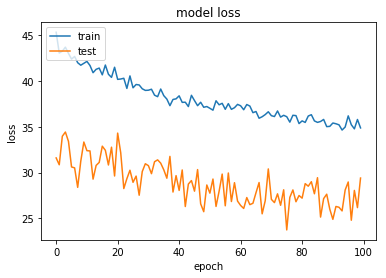

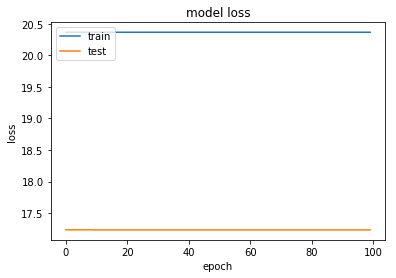

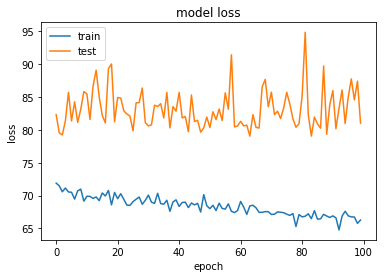

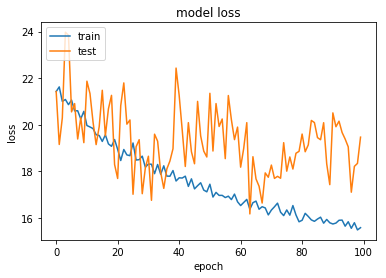

In [96]:
import matplotlib.pyplot as plt
for i in range(0,4):
    plt.plot(model_history[i].history['loss'])
    plt.plot(model_history[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [98]:
predictions=[]
for i in range(0,4):
    predictions.append(fitted_models[i].predict(x_test[i]))

predictions[0]

array([[ 0.      ],
       [21.461061],
       [90.827934],
       ...,
       [ 0.      ],
       [63.62904 ],
       [75.76812 ]], dtype=float32)

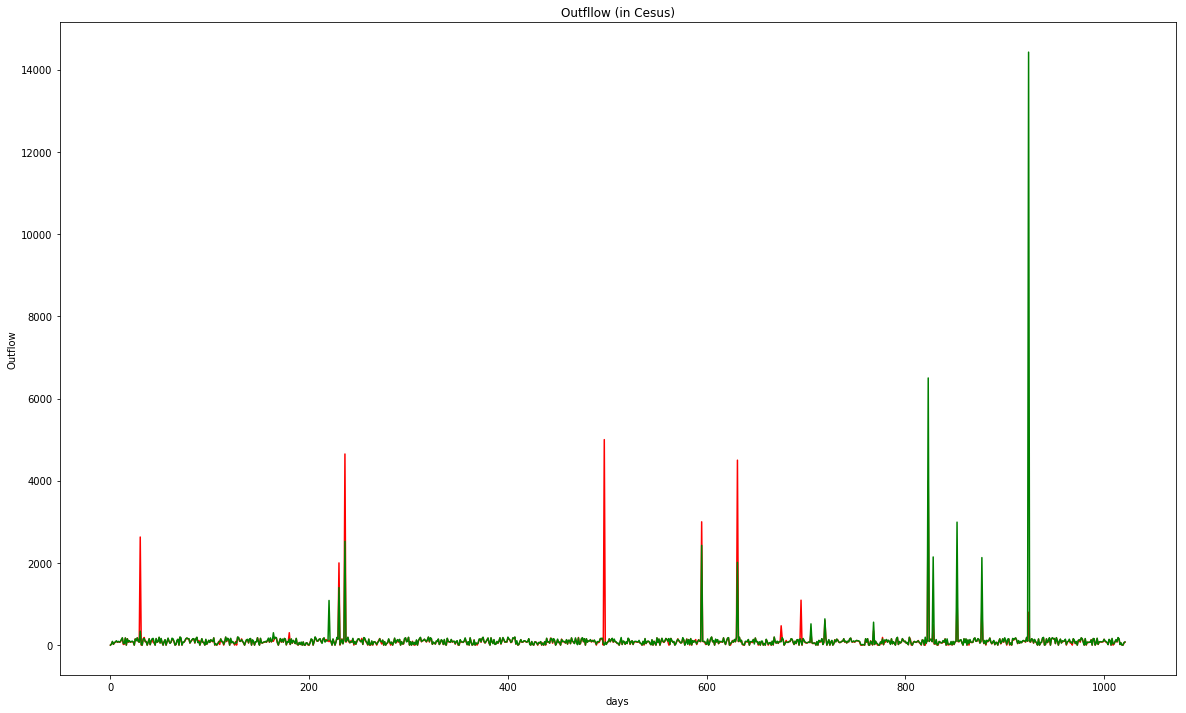

In [108]:
x=[]
for i in range(0,1022):
    x.append(i)
plt.figure(figsize=(20,12))
plt.plot(x,y_test[0], color= "red")
plt.plot(x, predictions[0], color = "green")
plt.title("Outfllow (in Cesus)")
plt.xlabel("days")
plt.ylabel("Outflow")
plt.show()

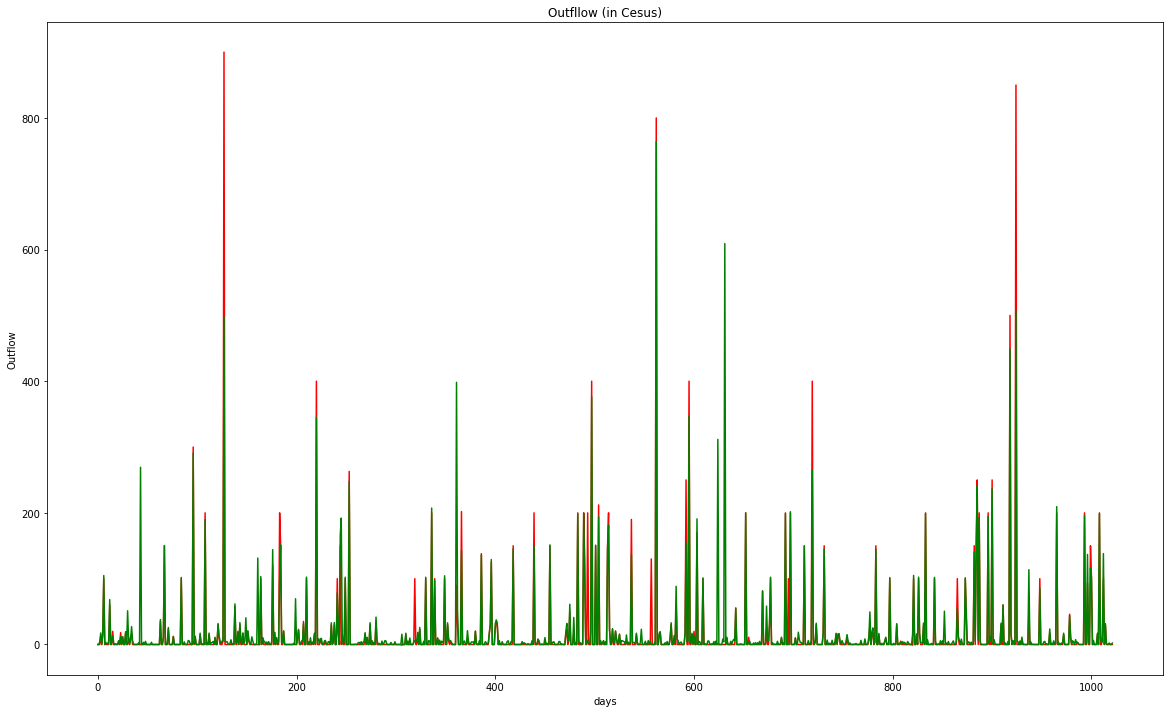

In [107]:
x=[]
for i in range(0,1022):
    x.append(i)
plt.figure(figsize=(20,12))
plt.plot(x,y_test[1], color= "red")
plt.plot(x, predictions[1], color = "green")
plt.title("Outfllow (in Cesus)")
plt.xlabel("days")
plt.ylabel("Outflow")
plt.show()

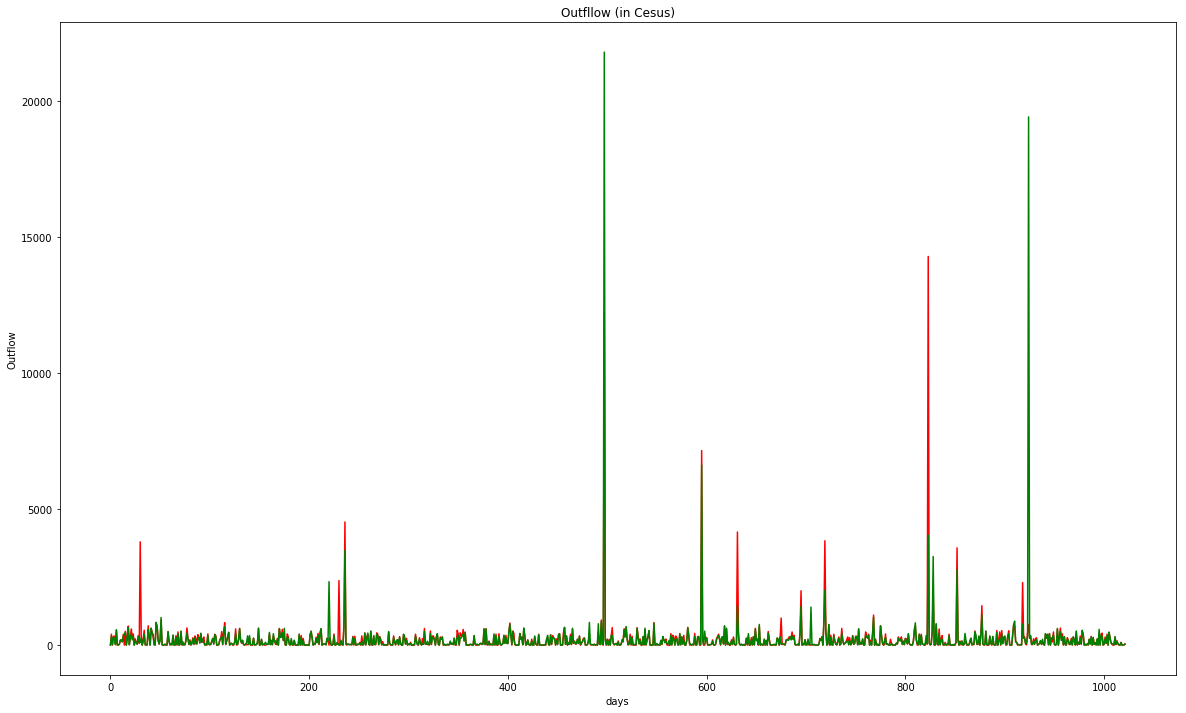

In [106]:
x=[]
for i in range(0,1022):
    x.append(i)
plt.figure(figsize=(20,12))
plt.plot(x,y_test[2], color= "red")
plt.plot(x, predictions[2], color = "green")
plt.title("Outfllow (in Cesus)")
plt.xlabel("days")
plt.ylabel("Outflow")
plt.show()

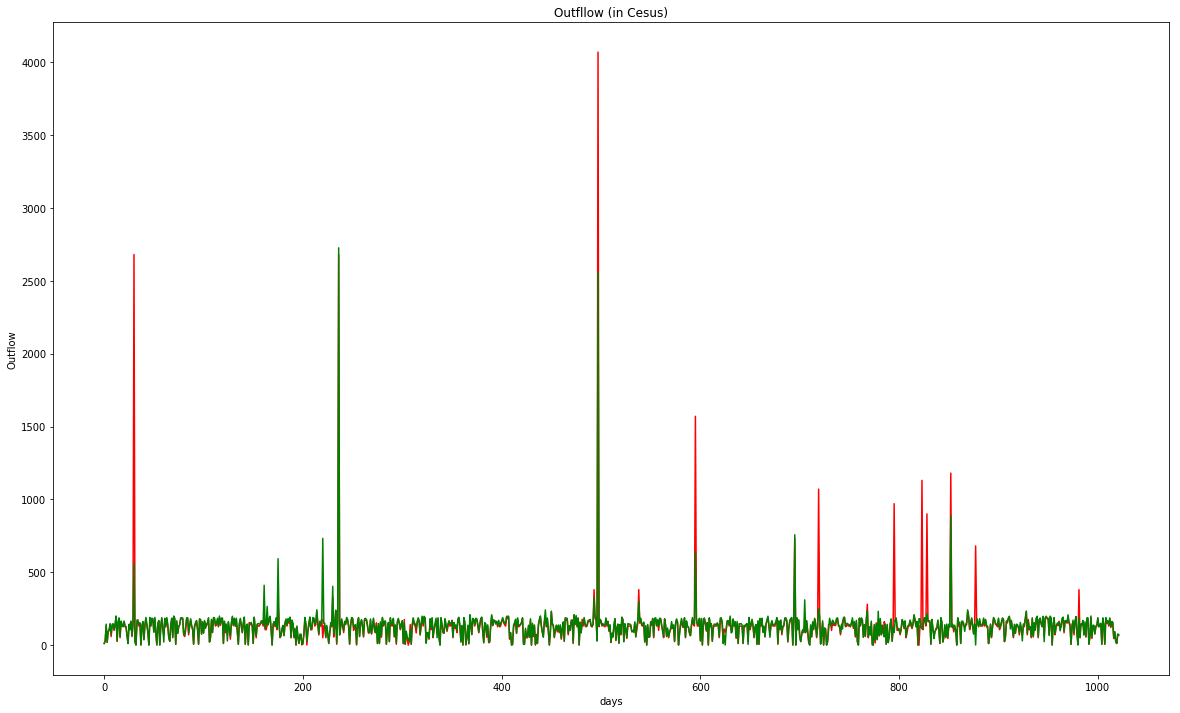

In [105]:
x=[]
for i in range(0,1022):
    x.append(i)
plt.figure(figsize=(20,12))
plt.plot(x,y_test[3], color= "red")
plt.plot(x, predictions[3], color = "green")
plt.title("Outfllow (in Cesus)")
plt.xlabel("days")
plt.ylabel("Outflow")
plt.show()